# 0. Install Dependencies and Bring in Data

In [6]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [7]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [8]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [9]:
from tensorflow.keras.layers import TextVectorization

In [10]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [11]:
MAX_FEATURES = 200000 # number of words in the vocab

In [14]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [15]:
vectorizer.adapt(X.values)

In [9]:
vectorized_text = vectorizer(X.values)

In [10]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [11]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding,Reshape

In [13]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [14]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [16]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 4656s 667ms/step - loss: 0.0619 - val_loss: 0.0454


In [17]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

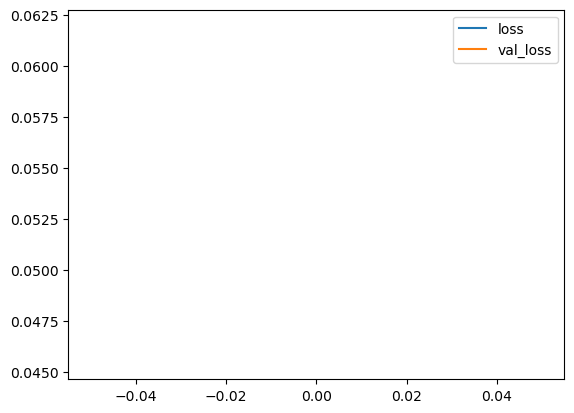

In [18]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [ ]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [39]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 57ms/step


In [40]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [41]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [42]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 79ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [43]:
res.shape

(1, 6)

# 4. Evaluate Model

In [44]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [26]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [27]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 72ms/step


In [46]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8247250914573669, Recall:0.6873090863227844, Accuracy:0.5015045404434204


# 5. Test and Gradio

In [29]:
!pip install gradio jinja2

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/107.3 kB ? eta -:--:--
     ----------- --------------------------- 30.7/107.3 kB 1.3 MB/s eta 0:00:01
     ----------- --------------------------- 30.7/107.3 kB 1.3 MB/s eta 0:00:01
     -------------- ---------------------- 41.0/107.3 kB 393.8 kB/s eta 0:00:01
     -------------- ---------------------- 41.0/107.3 kB 393.8 kB/s eta 0:00:01
     --------------------- --------------- 61.4/107.3 kB 252.2 kB/s eta 0:00:01
     --------------------- --------------- 61.4/107.3 kB 252.2 kB/s eta 0:00:01
     ------------------------------------ 107.3/107.3 kB 344.3 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of fastapi to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/12.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibm-cloud-sdk-core 3.18.0 requires urllib3<2.0.0,>=1.26.18, but you have urllib3 2.2.1 which is incompatible.
ibm-cos-sdk-core 2.11.0 requires urllib3<1.27,>=1.26.7, but you have urllib3 2.2.1 which is incompatible.
spacy 3.7.2 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
wxai-langchain 0.0.4 requires pydantic<=1.10.10, but you have pydantic 2.7.1 which is incompatible.
wxai-langchain 0.0.4 requires urllib3<2, but you have urllib3 2.2.1 which is incompatible.


In [48]:
model.save('toxicity.h5')

In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
# import gradio as gr

In [2]:
model = tf.keras.models.load_model('toxicity.h5')

In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras.layers import TextVectorization
model = tf.keras.models.load_model('toxicity.h5')
MAX_FEATURES = 200000
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))
X = df['comment_text']
vectorizer.adapt(X.values)

In [2]:
input_str = vectorizer('Bad product')
res = model.predict(np.expand_dims(input_str,0))
res[0][0]

1/1 [==============================] - 0s 473ms/step


0.009818339

In [3]:
input_str = vectorizer('Good product')
res = model.predict(np.expand_dims(input_str,0))
res[0][0]

1/1 [==============================] - 0s 52ms/step


0.0020932725

In [3]:
input_str = vectorizer('recomended')
res = model.predict(np.expand_dims(input_str,0))
res[0][0]

1/1 [==============================] - 0s 58ms/step


0.019999385

In [3]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 480ms/step


In [4]:
res[0][0]

0.0020932725

In [36]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [37]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

AttributeError: module 'gradio' has no attribute 'inputs'

In [ ]:
interface.launch(share=True)